<a href="https://www.kaggle.com/paulwightmore/ai-synth?scriptVersionId=86571645" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from typing import Iterable, Mapping

Question: What would it take to create an AI based synth.
Answer: I have no idea, but let's give it a shot.

**Part I - Waveform characteristics**

Given a fixed size waveform, can we use AI to categorise the input and to provide a set of outputs representing the waveforms characteristics?

What characteristics?

- Type (sine, sawtooth, square)
- Phase (0.0 0 degs, 1.0 180 degs)
- Attack (0.0 not attack - whatever that means, 1.0 instant on)
- Volume/power
- Decay (0.0 does not decay, 1.0 instant off)
- Harmonics (various standard harmonics e.g. 3rd_harmonic - 0.0 harmonic does not exist, 1.0 harmonic at full intensity)

**Part II - Waveform generation**

Given a set of user controlable characteristics produce a suitable waveform - this could be done, for example, by using sliders for assigning the amount by which a characteristic is present in the output waveform.

**Part III - ???**

???

...some time later...

**Part IV - Fully functional AI generating wavetable synthesizer**

...some more time later...

**Part V - Generate waveform parameters from real instrument samples**

Analyse a sample of a real instrument in order to generate a set of characteristics that allows the sample to be regenerated as closely as the model will allow (given an abundance of additional parameters, temporal capabilities).

What to make your new piano sample more synthetic? No problem just adjust the sine and sawtooth characteristic sliders and watch your new waveform transform in near real time.

Disclaimer: I have no intention of seeing this through, maybe I'll play around to see what I can come up with for part I and part II.
Additional disclaimer: I have no professional nor practical experience of neural nets and I am using the above as an exercise in broadaning my experience.

First things first. Let's provide a wave of generating some waveforms in code. From this we can then generate a series of samples and build up a dataset library...

In [2]:
import math

class context:
    def __init__(self, sample_rate: int):
        self.sample_rate = sample_rate
        
    def __str__(self):
        return f'context(sample_rate: {self.sample_rate})'
    
    #def sample_rate(self):
    #    return self.sample_rate
        
class waveform_generator:
    def __init__(self, context: context, phase: float):
        self.context = context
        self.phase = phase
    

Set up a basic test environment that will allow us to plot our generator classes

In [3]:
def signal_plot(samples: np.array, index, title: str = None):
    df = pd.DataFrame(samples, index)
    df.plot(title = title)
    
def waveform_generator_plot(generator: waveform_generator, timespan):
    
    def array_generator(generator, timespan):
        for t in timespan:
            yield generator.generate_sample(t)

    waveform = np.fromiter(array_generator(generator, timespan), float)
    signal_plot(waveform, timespan)

default_step = 0.1;
default_timespan = 1.0;
default_timespan_range = np.arange(0.0, default_timespan + default_step, default_step);

ctx = context(sample_rate=48)

Plot the out put of the sine generator

In [4]:
class sine_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def generate_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return math.sin(2.0 * math.pi * t)


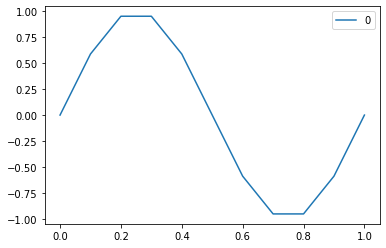

In [5]:
sine_gen = sine_wave_generator(ctx)

waveform_generator_plot(sine_gen, default_timespan_range)

In [6]:
class cosine_wave_generator(sine_wave_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase + 0.25)


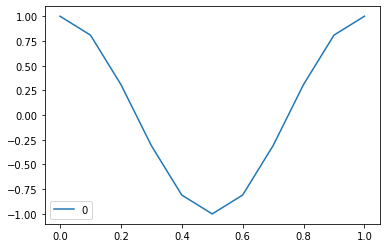

In [7]:
cosine_gen = cosine_wave_generator(ctx)

waveform_generator_plot(cosine_gen, default_timespan_range)

Now let's create a simple square wave generator

In [8]:
class square_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def generate_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 1.0 if t < 0.5 else -1.0 

Plot the out put of the square wave generator

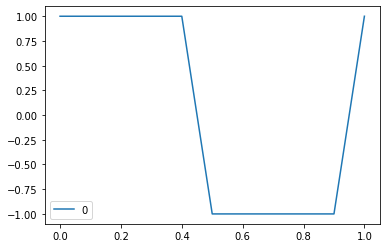

In [9]:
square_gen = square_wave_generator(ctx)

waveform_generator_plot(square_gen, default_timespan_range)

That was pretty straight forward, a sawtooth generator shouldn't be that much more of a stretch.

In [10]:
class sawtooth_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def generate_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 2.0 * (t if t < 0.5 else t - 1.0)

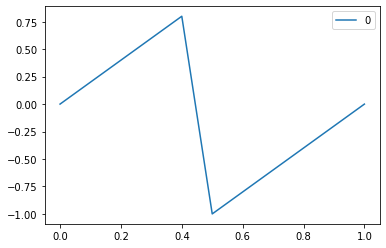

In [11]:
sawtooth_gen = sawtooth_wave_generator(ctx, phase = 0.0)

waveform_generator_plot(sawtooth_gen, default_timespan_range)

We have some generator classes, now let's create a class for generating a series of samples at a given frequency over a given period of time

Firstly from previous iterations, there was a need for some helper functions for manipulating sample and time conversions; more importantly some of these functions provided the ability to be implemented as [generators]<sup>*</sup>.(https://realpython.com/introduction-to-python-generators/)

<sup>*</sup>My goal is to avoid passing around huge arrays of numbers where ever possible.

In [12]:
class sample_context_helper:
    def __init__(self, context: context):
        self.context = context
    
    def time_range(self, t1: float, t2: float, t_steps: int):
        dt = (t2 - t1) / t_steps
        for s in range(0, t_steps + 1):
            yield t1 + s * dt
        
    def sample_count_to_timespan(self, sample_count: int): 
        return float(sample_count) / float(self.context.sample_rate)
        
    def sample_count_to_time_range(self, sample_count: int, sample_offset: int = 0):
        for s in range(sample_offset, (sample_count + sample_offset + 1)):
            yield s / self.context.sample_rate
            
    def timespan_to_sample_count(self, timespan: float): 
        return int(0.5 + timespan * self.context.sample_rate)
    
    def timespan_to_time_range(self, timespan: float, time_offset: float = 0.0):
        sample_count = self.timespan_to_sample_count(timespan)
        sample_count += self.timespan_to_sample_count(time_offset)
        return self.sample_count_to_time_range(sample_count)


Let's quickly test that.

In [13]:
ctx_hlp = sample_context_helper(ctx)

print(f'1 sec = {ctx_hlp.timespan_to_sample_count(1.0)} samples')
print(f'2.5 sec = {ctx_hlp.timespan_to_sample_count(2.5)} samples')
print(f'48 samples = {ctx_hlp.sample_count_to_timespan(48)} secs')
print(f'120 samples = {ctx_hlp.sample_count_to_timespan(120)} secs')

print("time range of 1 sec to 2.5 sec over 10 steps:")
time_range = np.fromiter(ctx_hlp.time_range(1.0, 2.5, 10), float)
print(time_range)

print("time range of 48 samples:")
time_range = np.fromiter(ctx_hlp.sample_count_to_time_range(48), float)
print(time_range)

print("time range of 1 sec:")
time_range = np.fromiter(ctx_hlp.timespan_to_time_range(1.0), float)
print(time_range)

default_timespan_range = np.fromiter(ctx_hlp.timespan_to_time_range(default_timespan), float)

1 sec = 48 samples
2.5 sec = 120 samples
48 samples = 1.0 secs
120 samples = 2.5 secs
time range of 1 sec to 2.5 sec over 10 steps:
[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35 2.5 ]
time range of 48 samples:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.41666667 0.4375     0.45833333 0.47916667
 0.5        0.52083333 0.54166667 0.5625     0.58333333 0.60416667
 0.625      0.64583333 0.66666667 0.6875     0.70833333 0.72916667
 0.75       0.77083333 0.79166667 0.8125     0.83333333 0.85416667
 0.875      0.89583333 0.91666667 0.9375     0.95833333 0.97916667
 1.        ]
time range of 1 sec:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.

In [14]:
class signal_generator:
    def __init__(self, context: context, frequency: float, amplitude: float, phase: float, bias: float, attenuation: float):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        self.frequency = frequency
        self.amplitude = amplitude
        self.phase = phase
        self.bias = bias
        self.attenuation = attenuation
        
    def _calc_t(self, timepoint: float):
        return self.phase + timepoint * self.frequency
    
    def _generate_raw_sample(self, t: float):
        return 0.0
    
    def _generate_samples(self, timespan: float):
        #amplitude = 1.0 - self.attenuation
        t1 = self._calc_t(0)
        t2 = self._calc_t(timespan)
        sample_count = self.ctx_hlp.timespan_to_sample_count(timespan)
        for t in self.ctx_hlp.time_range(t1, t2, sample_count):
            yield self.bias + self.amplitude * self._generate_raw_sample(t)
            
    def generate_sample(self, timepoint: float):
        #amplitude = 1.0 - self.attenuation
        
        t = self._calc_t(timepoint)
        return self.amplitude * self._generate_raw_sample(t)
    
    def generate_samples(self, timespan: float):
        return np.fromiter(self._generate_samples(timespan), float)
    
class waveform_signal_generator(signal_generator):
    def __init__(self, context: context, generator: waveform_generator, frequency: float, amplitude: float = 1.0, phase: float = 0.0, bias: float = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generator = generator
        
    def _generate_raw_sample(self, t: float):
        return self.generator.generate_sample(t)


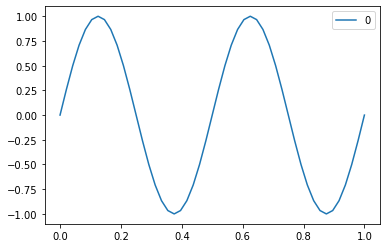

In [15]:
sine_sig_gen_2hz = waveform_signal_generator(ctx, sine_gen, frequency = 2.0)

waveform = sine_sig_gen_2hz.generate_samples(default_timespan)

signal_plot(waveform, default_timespan_range)


Test sine wave again, this time with a phase shift applied at the signal generator level

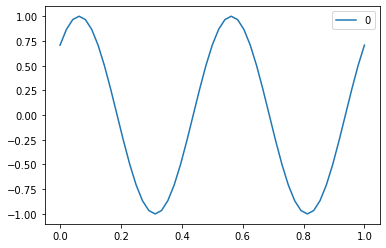

In [16]:
sine_sig_gen_2hz_45degs = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, phase = 0.125)

waveform = sine_sig_gen_2hz_45degs.generate_samples(default_timespan)

signal_plot(waveform, default_timespan_range)

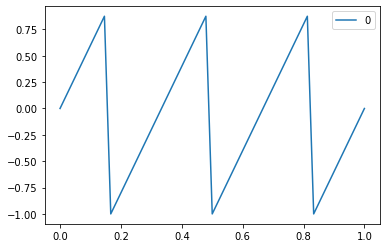

In [17]:
saw_sig_gen_3hz = waveform_signal_generator(ctx, sawtooth_gen, frequency = 3.0)

waveform = saw_sig_gen_3hz.generate_samples(default_timespan)

signal_plot(waveform, default_timespan_range)

By adding attenuation and bias, we should be able to push a square wave from -1.0 => 1.0 into the 0.0 => 1.0 range

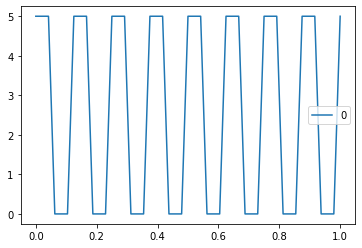

In [18]:
clock_sig_gen_5hz = waveform_signal_generator(ctx, square_gen, frequency = 8.0, amplitude = 2.5, bias = 2.5)

waveform = clock_sig_gen_5hz.generate_samples(default_timespan)

signal_plot(waveform, default_timespan_range)

Okay, that's the basic signal generation in place. We have a method for creating various pure signals. At somepoint however we may want to start feeding more complex signals through out training program; the most prominent in my mind is how to provide support for harmonics.

We can achieve a more complex signal by mixing<sup>*</sup> multiple signals together...

<sup>*</sup> need to find a more suitable technical term (compositing?)

In [19]:
class compositing_signal_generator(signal_generator):
    def __init__(self, context: context, generators: Iterable[signal_generator], frequency: float = 1.0, amplitude: float = 1.0, phase: float = 0.0, bias = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generators = generators
        
    def _generate_raw_sample(self, t: float):
        sum = 0.0
        for generator in self.generators:
            sum += generator.generate_sample(t)
        return sum
    

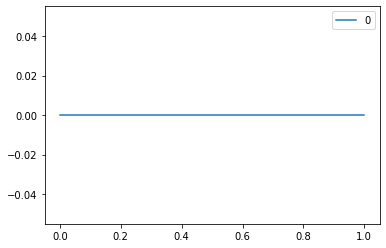

In [20]:
null_signal_generator = compositing_signal_generator(ctx, [])

waveform = null_signal_generator.generate_samples(default_timespan)

signal_plot(waveform, default_timespan_range)

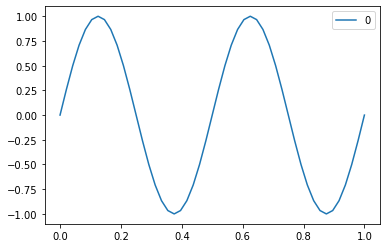

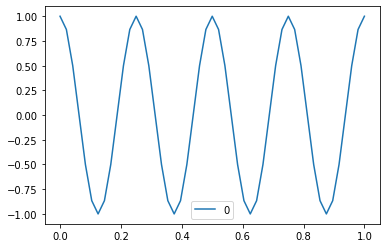

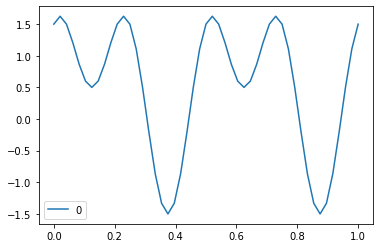

In [21]:
gen1 = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, attenuation = 0.1)
gen2 = waveform_signal_generator(ctx, sine_gen, frequency = 4.0, attenuation = 0.3, phase = 0.25)
comp2_signal_generator = compositing_signal_generator(ctx, [gen1, gen2], bias = 0.5)

in1 = gen1.generate_samples(default_timespan)
in2 = gen2.generate_samples(default_timespan)
out = comp2_signal_generator.generate_samples(default_timespan)

signal_plot(in1, default_timespan_range)
signal_plot(in2, default_timespan_range)
signal_plot(out, default_timespan_range)

My original plan was to somehow use the above generators to generate data tables for storing in some form of overly complicated JSON based data structure. However, as the generators are here and available to use, I may as well store the characteristics of various wave formation in a CSV and then dynamically generate the waveforms required for further processing.

In [22]:
class waveform_generator_factory:
    def __init__(self, context: context):
        self.context = context
        self.generators = {
             'sine': sine_wave_generator,
             'cosine' : cosine_wave_generator,
             'square' : square_wave_generator,
             'sawtooth' : sawtooth_wave_generator}
            
    def create_generator(self, name: str) -> waveform_generator:
        return self.generators[name](self.context)
            
        
class waveform_signal_generator_factory:
    def __init__(self, context: context, waveform_generator_factory: waveform_generator_factory):
        self.context = context
        self.waveform_generator_factory = waveform_generator_factory
        
    def create_signal_generators(self, data: pd.DataFrame) -> Mapping[str, waveform_signal_generator]:
        sig_gens = {}
        for index, row in data.iterrows():
            
            name = row['name']
            type = row['type']
            frequency = row.get('frequency' , 0.0)
            amplitude = row.get('amplitude' , 1.0)
            phase = row.get('phase' , 0.0) / 360.0 # degs to revolutions
            bias = row.get('bias' , 0.0)
            generator = self.waveform_generator_factory.create_generator(type)
            sig_gens[name] = waveform_signal_generator(self.context, generator, frequency, amplitude, phase, bias)
            
        return sig_gens
            
            

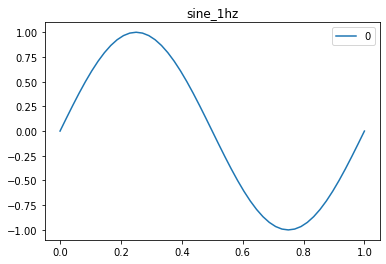

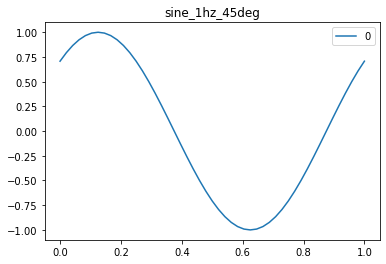

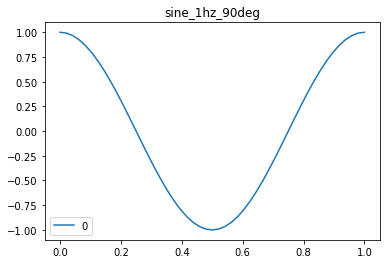

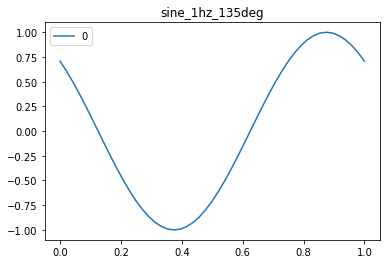

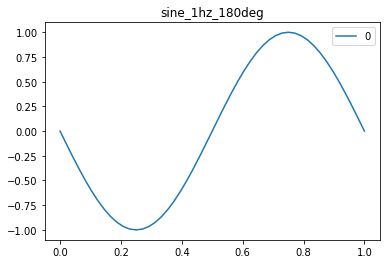

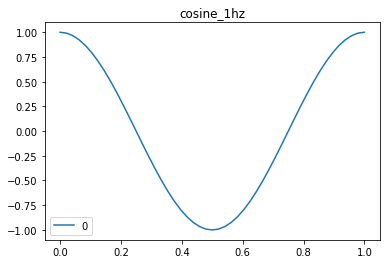

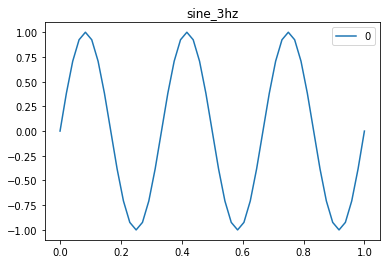

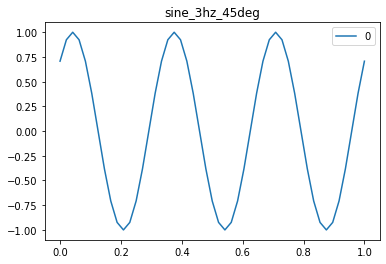

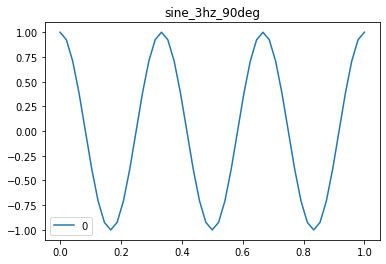

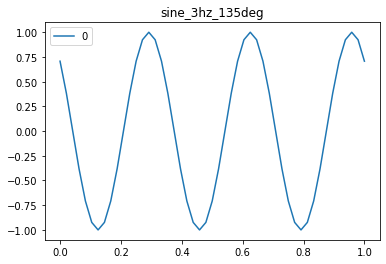

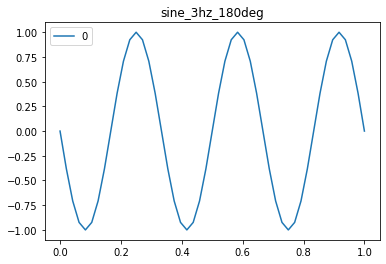

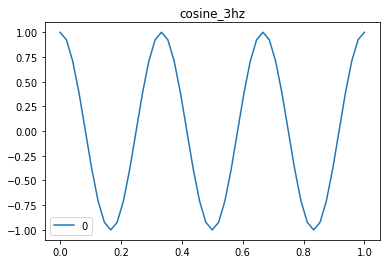

In [23]:
df = pd.DataFrame(
    [['sine_1hz', 'sine', 1.0, 1.0, 0, 0.0],
     ['sine_1hz_45deg', 'sine', 1.0, 1.0, 45.0, 0.0],
     ['sine_1hz_90deg', 'sine', 1.0, 1.0, 90.0, 0.0],
     ['sine_1hz_135deg', 'sine', 1.0, 1.0, 135.0, 0.0],
     ['sine_1hz_180deg', 'sine', 1.0, 1.0, 180.0, 0.0],
     ['cosine_1hz', 'cosine', 1.0, 1.0, 0.0, 0.0],
     ['sine_3hz', 'sine', 3.0, 1.0, 0.0, 0.0],
     ['sine_3hz_45deg', 'sine', 3.0, 1.0, 45.0, 0.0],
     ['sine_3hz_90deg', 'sine', 3.0, 1.0, 90.0, 0.0],
     ['sine_3hz_135deg', 'sine', 3.0, 1.0, 135.0, 0.0],
     ['sine_3hz_180deg', 'sine', 3.0, 1.0, 180.0, 0.0],
     ['cosine_3hz', 'cosine', 3.0, 1.0, 0, 0.0]],
    columns=['name', 'type', 'frequency', 'amplitude', 'phase', 'bias'])

wgf = waveform_generator_factory(ctx)
wfsg = waveform_signal_generator_factory(ctx, wgf)
sig_gens = wfsg.create_signal_generators(df)
for sig_gen_item in sig_gens.items():
    signal = sig_gen_item[1].generate_samples(default_timespan)
    signal_plot(signal, default_timespan_range, title = sig_gen_item[0])
    